In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
np.random.seed(99)

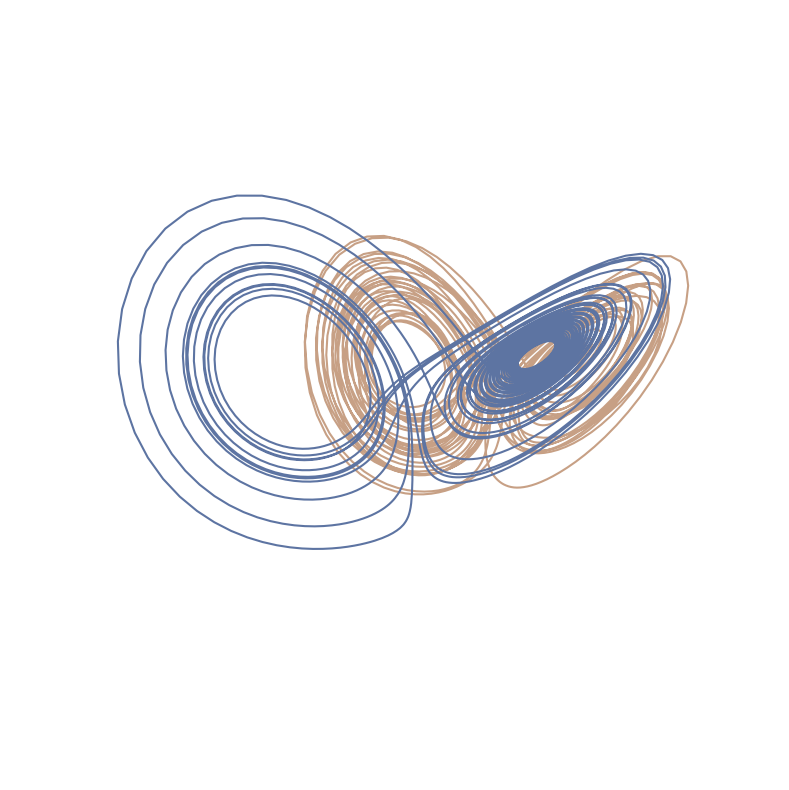

In [3]:
# Generate data

N_washout = 100
N_train   = 3000
N_tstart  = 3000
N_test    = 500

N_x = 2

N_dim   = 3 * N_x # dimension of inputs (and outputs)
N_units = 100 * N_dim #units in the reservoir 

A = np.array([[0,1],[0,0]])
%run ./Lorenz_data.ipynb

X = gen_data_norm(N_x, A, N_tstart+N_test, sigma_dyn = 1e-4, sigma_obs = 1e-4)

# washout
X_washout = X[:N_washout]
# training
X_t = X[N_washout:N_washout+N_train-1]
Y_t = X[N_washout+1:N_washout+N_train]

X_test = X[N_tstart:]


gtcolors = ['#C7A085', '#5D74A2']
plotcolors = ['#0E419C', '#CC1A1A']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
for i in range(N_x):
    ax.plot(*X[:,i*3:i*3+3].T, color=gtcolors[i])
plt.axis('off')

filename = f"LorenzData"
pathname = f"./results/{filename}.png"
plt.savefig(pathname)

plt.show()

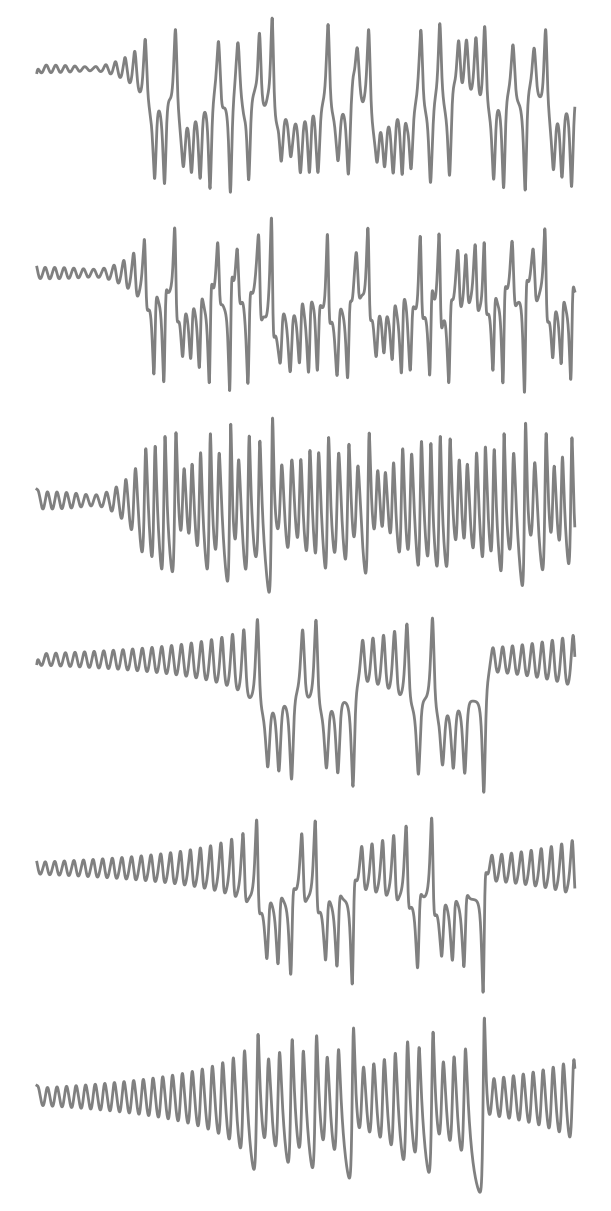

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(6, 2*N_dim))
axs = fig.subplots(N_dim, 1)
for i in range(N_dim):
#     fig = plt.figure(constrained_layout=True, figsize=(6, 3))
#     ax = fig.subplots()
    axs[i].plot(X.T[i], '-', label="close-loop", linewidth=2.0, color='grey', alpha=1, ms=10)
    axs[i].axis('off')
    
filename = f"observation"
pathname = f"./results/{filename}.png"
plt.savefig(pathname, bbox_inches = 'tight')
plt.show()

In [5]:
# train the RC

%run ./ESN.ipynb
    
esn = ESN(N_units, N_dim, N_dim)
esn.train(X_washout, X_t, Y_t)
print('train finish')

train finish


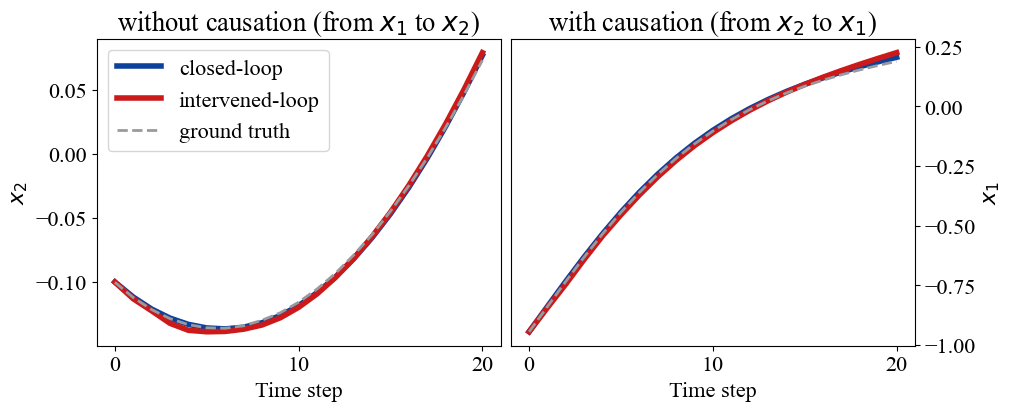

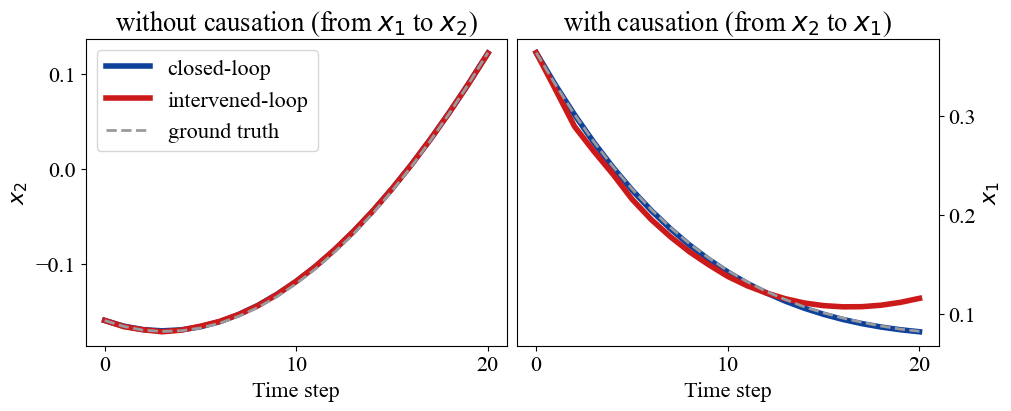

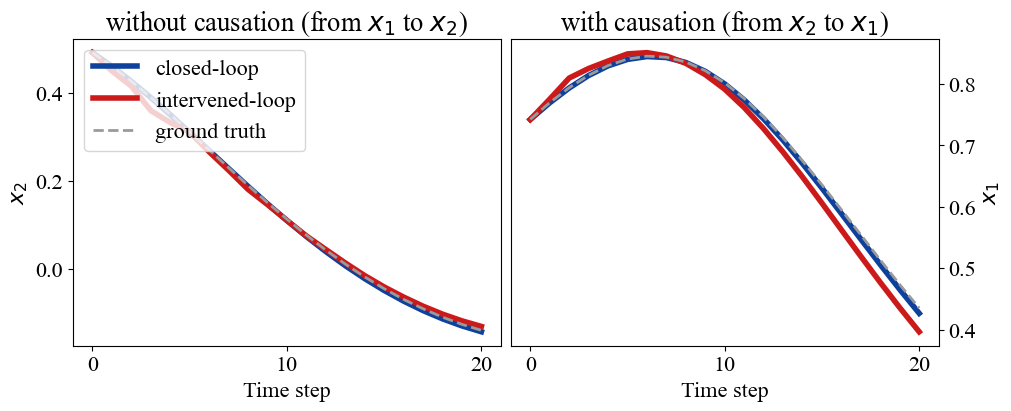

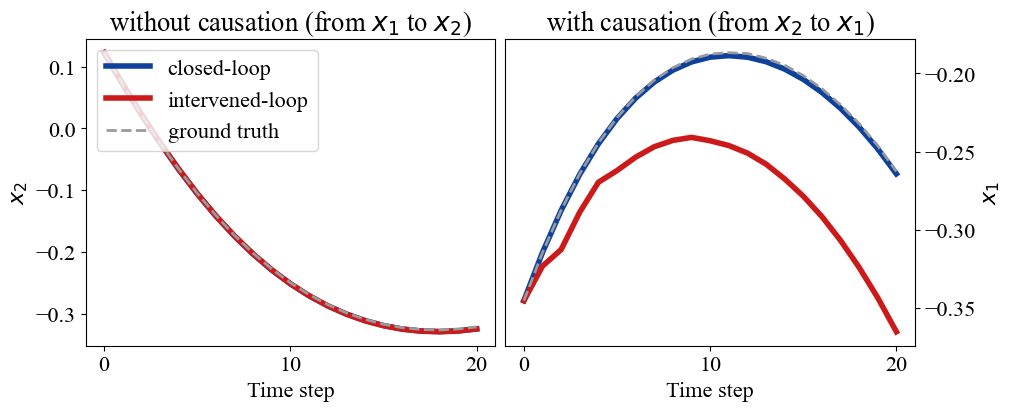

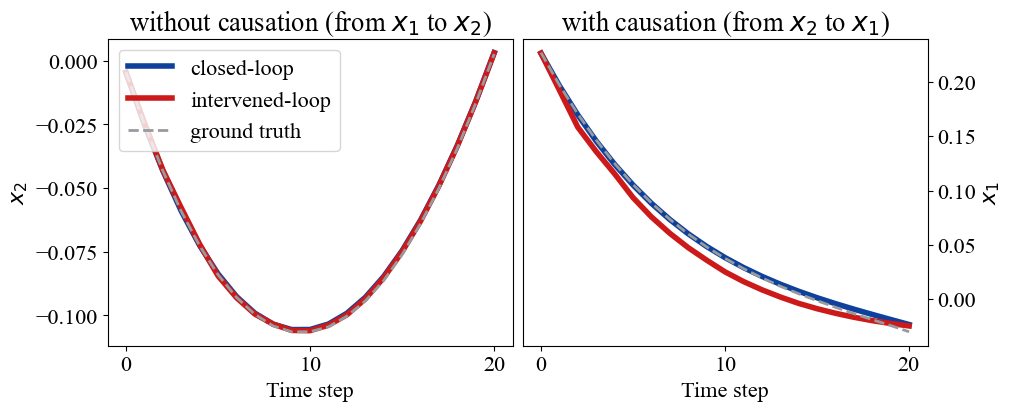

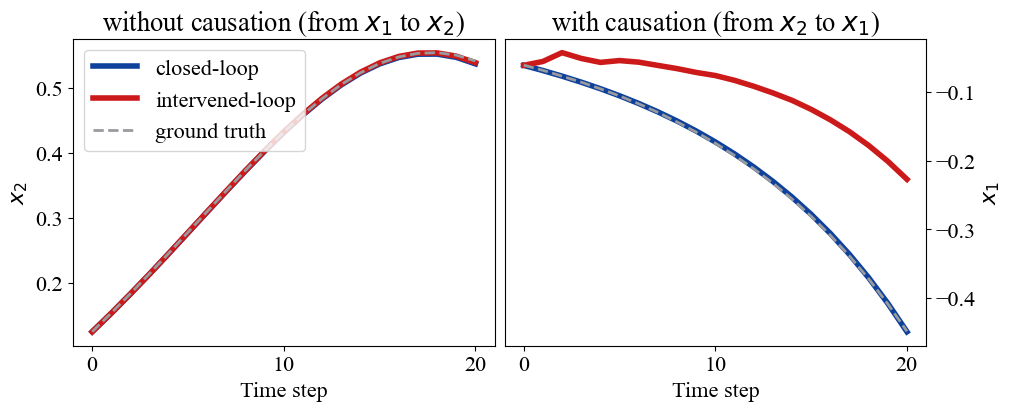

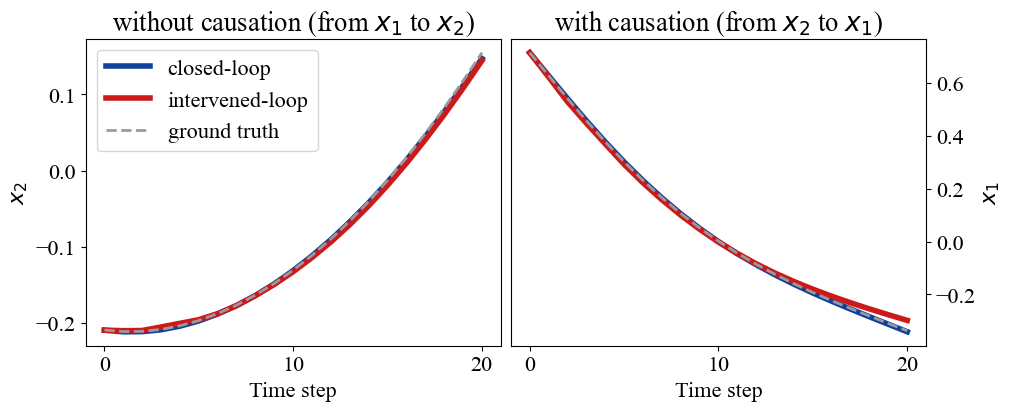

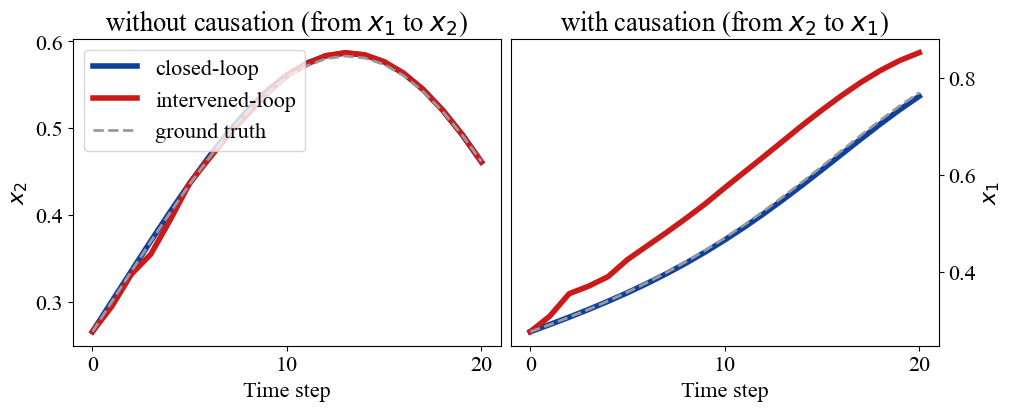

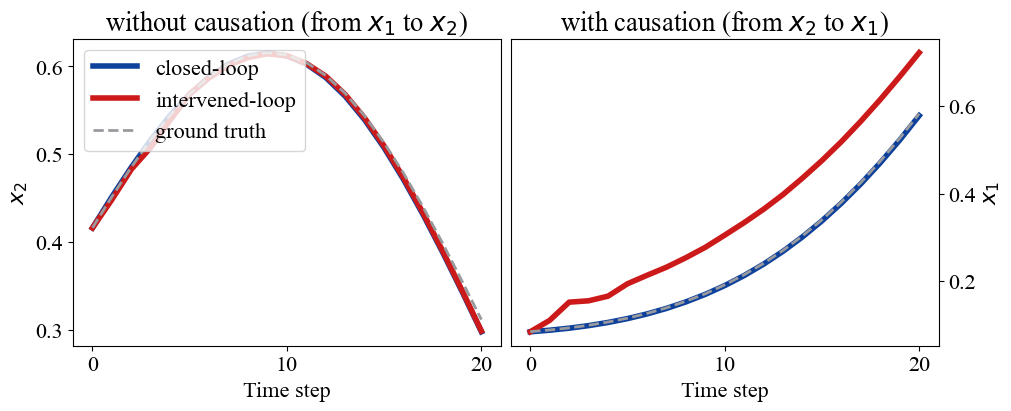

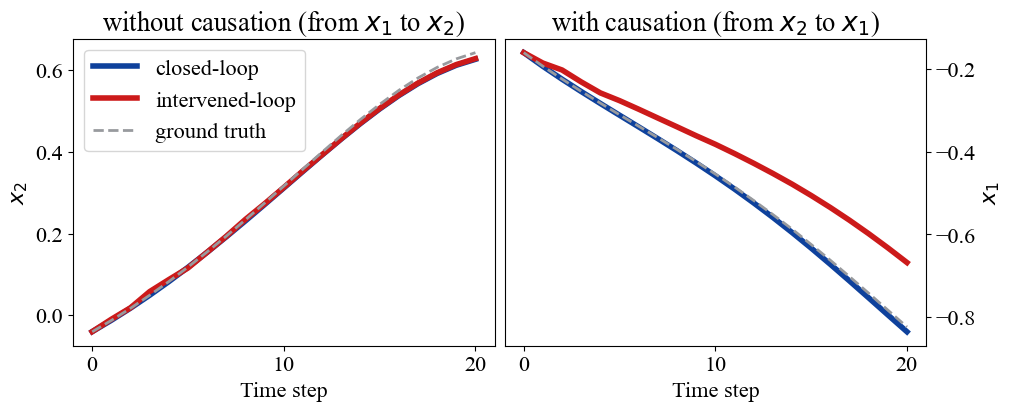

In [6]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["font.size"] = 16

r0s = []
for pic in range(10):
    fig = plt.figure(constrained_layout=True, figsize=(10, 4))

    axs = fig.subplots(1, 2)


    N_evo = 20
    offset = np.random.randint(N_test - N_evo)
    X_test_washout = X[N_tstart - N_washout + offset:N_tstart + offset]
    Y = X[N_tstart + offset : N_tstart + offset + N_evo + 1]
    X_delay = Y[:0]


    # idle iteration
    r0 = esn.open_loop(X_test_washout, np.zeros(N_units))[-1]
    r0s.append(r0)

    # the unintervened sequence x_CL
    Yh = esn.evolve(r0, N_evo)

    pairs = [[1,0],[0,1]]
    locs = ['upper left', 'lower right']

    for p in range(len(pairs)):
        i = pairs[p][0]
        j = pairs[p][1]

        targetI = 3*i
        targetJ = 3*j+1

        # the intervened sequence x_j->i 
        Yhji = esn.evolve_edge_removal(r0, targetJ, targetI, N_evo)

        ax = axs[p]

        ax.plot(Yh.T[targetI], '-', label="closed-loop", linewidth=4.0, color=plotcolors[0], alpha=1, ms=10)
        ax.plot(Yhji.T[targetI], '-', label="intervened-loop", linewidth=4.0, color=plotcolors[1], ms=10)
        ax.plot(Y.T[targetI], label="ground truth", linewidth=2.0, color='#989A9E', linestyle='--', alpha=1)


        ax.set_xlabel('Time step')
        ax.set_ylabel(f'$x_{i+1}$')
        ax.set_xticks(ticks=[0, (Yh.shape[0]-1) / 2, Yh.shape[0]-1])
        if p == 1:
            ax.yaxis.set_label_position('right')
            ax.yaxis.set_ticks_position('right')
        if p == 0:
            ax.legend(loc=locs[p])
        ax.set_title(f'{"with" if A[i,j]>0 else "without"} causation (from $x_{j+1}$ to $x_{i+1}$)')

    # fig.supxlabel('Time step')

    filename = f"TrajectoryVariation"
    pathname = f"./results/{filename}_{pic}.png"
    plt.savefig(pathname)

    plt.show()

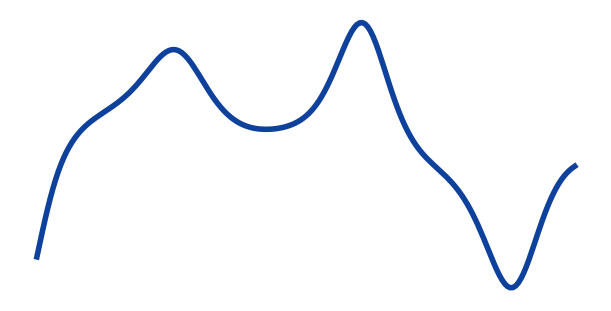

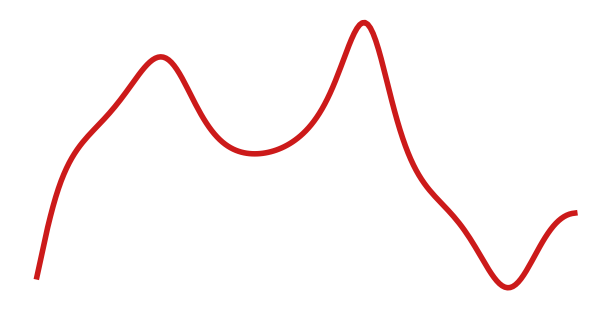

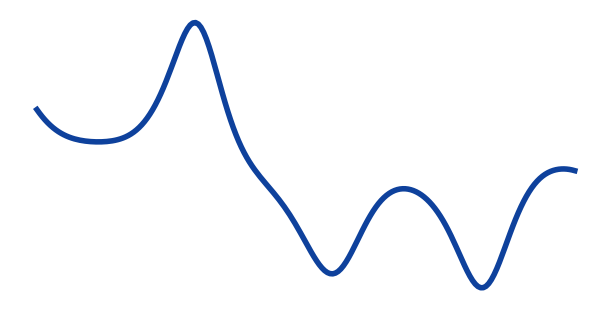

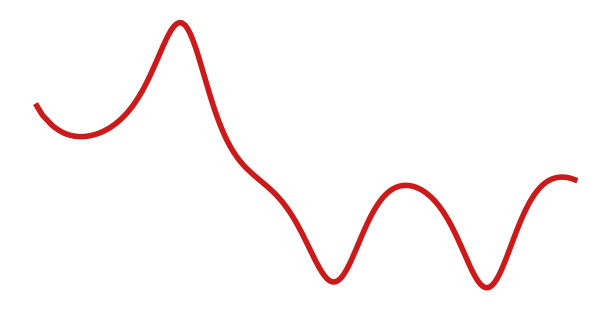

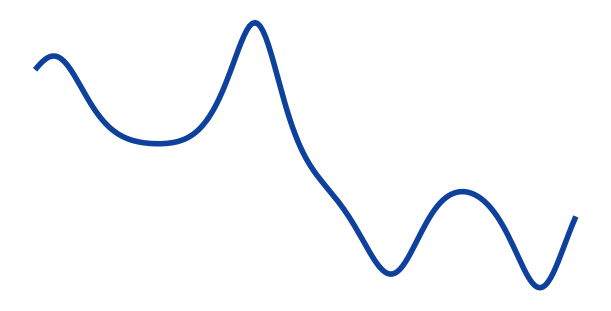

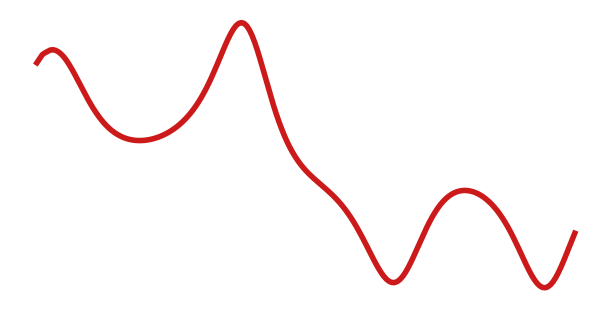

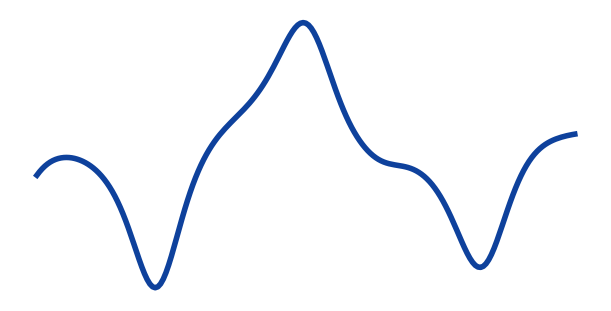

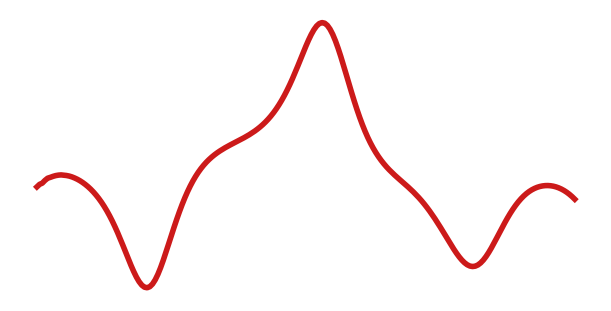

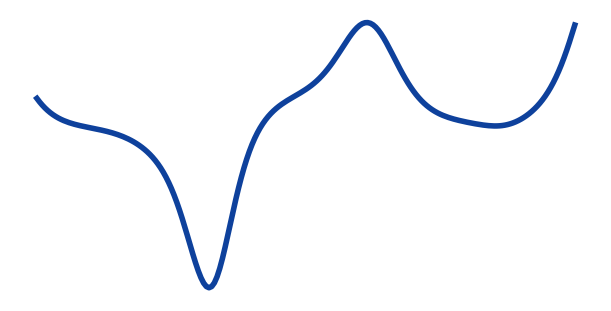

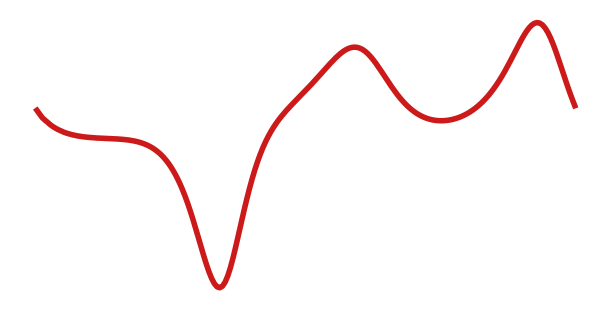

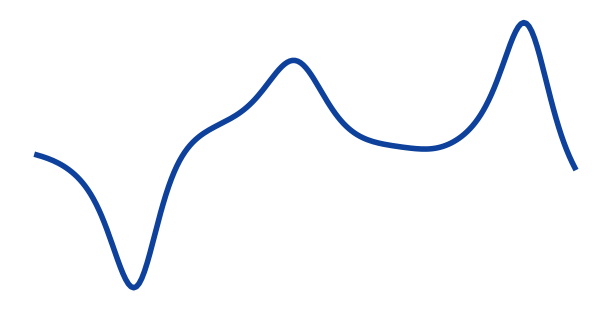

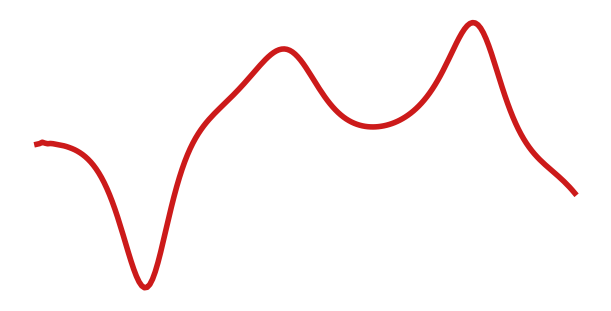

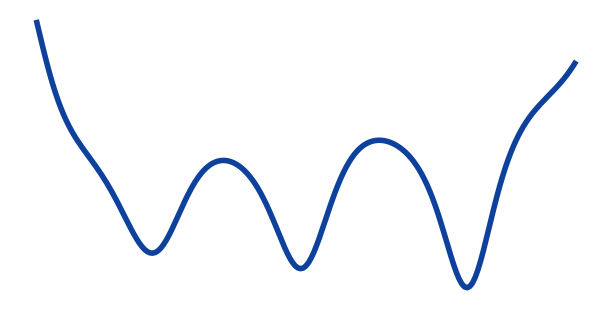

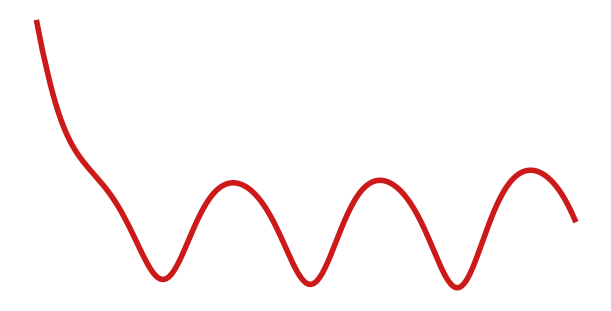

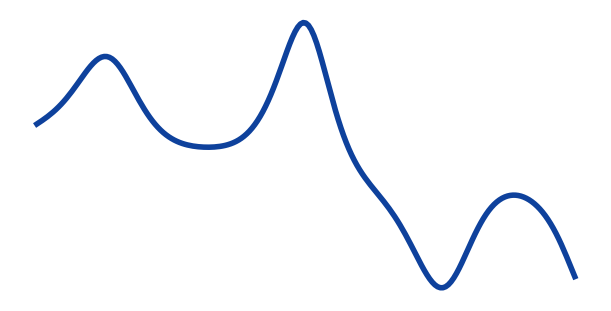

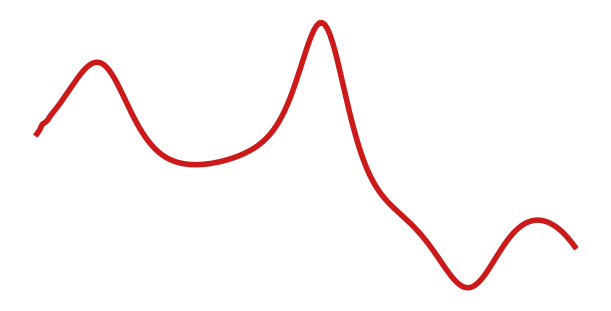

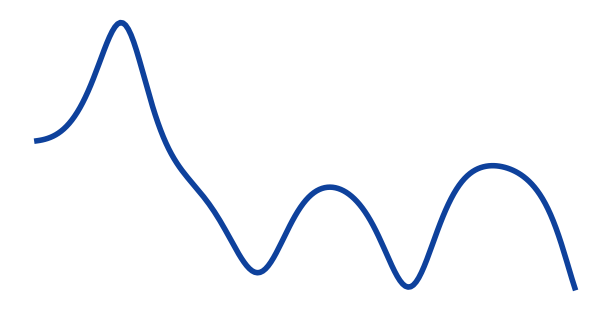

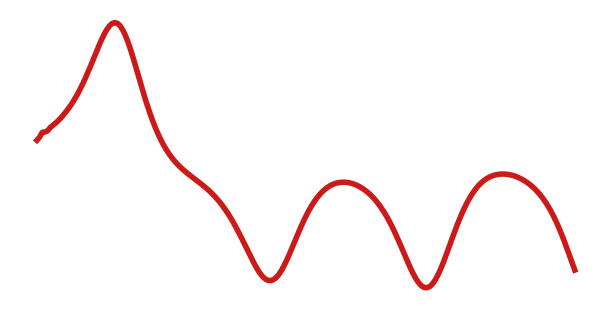

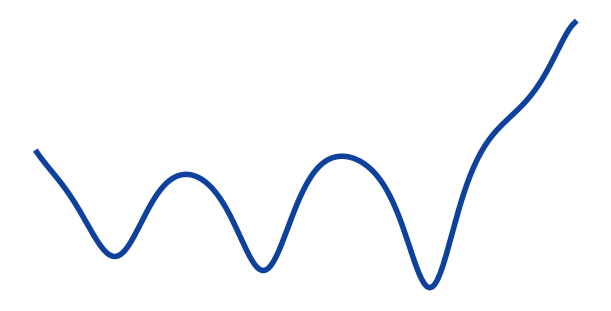

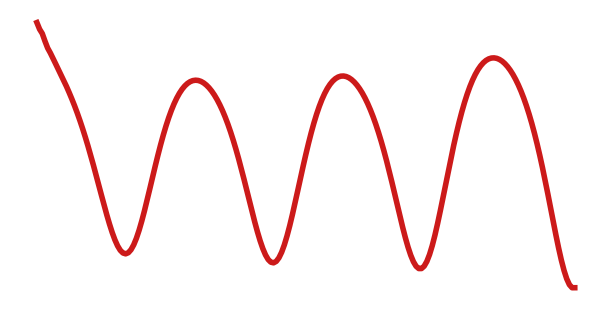

In [7]:
for pic in range(10):
    r0 = r0s[pic]

    Yhji1 = esn.evolve_edge_removal(r0, 4, 0, 200)
    Yhji2 = esn.evolve_edge_removal(r0, 0, 3, 200)
    Yh = esn.evolve(r0, 200)

    fig = plt.figure(constrained_layout=True, figsize=(6, 3))
    ax = fig.subplots()
    ax.plot(Yh.T[targetI], '-', label="close-loop", linewidth=4.0, color=plotcolors[0], alpha=1, ms=10)
    plt.axis('off')
    filename = f"Yh"
    pathname = f"./results/{filename}_{pic}.png"
    plt.savefig(pathname, bbox_inches = 'tight')
    plt.show()

    fig = plt.figure(constrained_layout=True, figsize=(6, 3))
    ax = fig.subplots()
    ax.plot(Yhji1.T[targetI], '-', label="intervened-loop", linewidth=4.0, color=plotcolors[1], ms=10)
    plt.axis('off')
    filename = f"Yhji"
    pathname = f"./results/{filename}_{pic}.png"
    plt.savefig(pathname, bbox_inches = 'tight')
    plt.show()

    # fig = plt.figure(constrained_layout=True, figsize=(6, 3))
    # ax = fig.subplots()
    # ax.plot(Yhji2.T[targetI], '-', label="intervened-loop", linewidth=4.0, color=plotcolors[1], ms=10)
    # plt.axis('off')
    # plt.show()


In [8]:
# Calculating TDI and reconstructing causal networks

%run ./Reconstruct.ipynb

N_rep, N_evo = 20, 20
TDI = cal_TDI(esn, X_test, N_x, 3, 0, 1, N_rep, N_washout, N_evo)

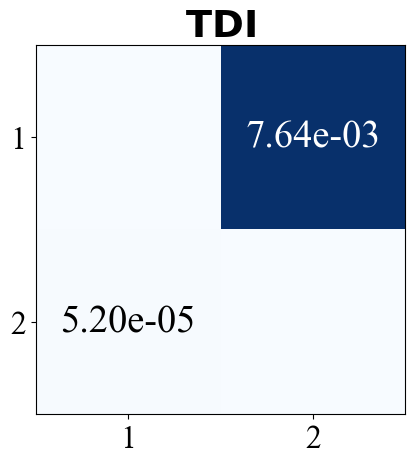

In [9]:
%run ./Plot_TDI.ipynb

plot_im_only(TDI, ['1','2'], [['','w'],['black','']])